# Generating single qubit clustered state with the quantum diffusion model

_Main_ libraries to install: ```torch```, ```tensorcircuit```, ```opt_einsum```, ```QuTip```, ```tqdm```, ```torch```

In [25]:
# import libraries

import torch
import random

import ot
import tensorcircuit as tc
import numpy as np
import scipy as sp
from scipy.stats import unitary_group
import torch
import torch.nn as nn
from torch.linalg import matrix_power
from opt_einsum import contract
from functools import partial
from itertools import combinations
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
from qutip import *

# settings
rc('text', usetex=True)
rc('axes', linewidth=3)
plt.rcParams.update({'font.size': 22})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['axes.linewidth'] = 1.5
K = tc.set_backend('pytorch')
# tc.set_dtype('complex64')

In [2]:
!pip3 install -U qiskit
!pip3 install -U cirq

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# Plotting on the Bloch (Poincare) sphere

In [4]:
def bloch_xyz(inputs):
    # obtain bloch sphere representation vector
    rho = contract('mi,mj->mij', inputs, inputs.conj())
    sigmas = [sigmax().full(), sigmay().full(), sigmaz().full()]
    pos = [np.real(contract('mii->m', contract('mij,jk->mik', rho, x))) for x in sigmas]
    return pos

# The (forward) Diffusion Class

In [53]:
class DiffusionModel(nn.Module):
    def __init__(self, n, T, Ndata):
        '''
        the diffusion quantum circuit model to scramble arbitrary set of states to Haar random states
        Args:
        n: number of qubits
        T: number of diffusion steps
        Ndata: number of samples in the dataset
        '''
        super().__init__()
        self.n = n
        self.T = T
        self.Ndata = Ndata
    
    def HaarSampleGeneration(self, Ndata, seed):
        '''
        generate random haar states,
        used as inputs in the t=T step for backward denoise
        Args:
        Ndata: number of samples in dataset
        '''
        np.random.seed(seed)
        states_T = unitary_group.rvs(dim=2**self.n, size=Ndata)[:,:,0]
        return torch.from_numpy(states_T).cfloat()
    
    def scrambleCircuit_t(self, t, input, phis, gs=None):
        '''
        obtain the state through diffusion step t
        Args:
        t: diffusion step
        input: the input quantum state
        phis: the single-qubit rotation angles in diffusion circuit
        gs: the angle of RZZ gates in diffusion circuit when n>=2
        '''
        c = tc.Circuit(self.n, inputs=input)
        for tt in range(t):
            # single qubit rotations
            for i in range(self.n):
                c.rz(i, theta=phis[3*self.n*tt+i])
                c.ry(i, theta=phis[3*self.n*tt+self.n+i])
                c.rz(i, theta=phis[3*self.n*tt+2*self.n+i])
            # homogenous RZZ on every pair of qubits (n>=2)
            if self.n >= 2:
                for i, j in combinations(range(self.n), 2):
                    c.rzz(i, j, theta=gs[tt]/(2*np.sqrt(self.n)))
        return c.state()
    
    def set_diffusionData_t(self, t, inputs, diff_hs, seed):
        '''
        obtain the quantum data set through diffusion step t
        Args:
        t: diffusion step
        inputs: the input quantum data set
        diff_hs: the hyper-parameter to control the amplitude of quantum circuit angles
        '''
        # set single-qubit rotation angles
        np.random.seed(seed)
        phis = torch.rand(self.Ndata, 3*self.n*t)*np.pi/4. - np.pi/8.
        phis = phis*(diff_hs.repeat(3*self.n))
        if self.n > 1:
            # set homogenous RZZ gate angles
            gs = torch.rand(self.Ndata, t)*0.2 + 0.4
            gs *= diff_hs
        states = torch.zeros((self.Ndata, 2**self.n)).cfloat()
        for i in range(self.Ndata):
            if self.n > 1:
                states[i] = self.scrambleCircuit_t(t, inputs[i], phis[i], gs[i])
            else:
                states[i] = (self.scrambleCircuit_t(t, inputs[i], phis[i]))
        return states


# One time-step of the PQC in the denoising process (before measurement, parameter dependent)

In [6]:
def backCircuit(input, params, n_tot, L):
    '''
    the backward denoise parameteric quantum circuits,
    designed following the hardware-efficient ansatz
    output is the state before measurmeents on ancillas
    Args:
    input: input quantum state of n_tot qubits
    params: the parameters of the circuit
    n_tot: number of qubits in the circuits
    L: layers of circuit
    '''
    c = tc.Circuit(n_tot, inputs=input)
    for l in range(L):
        for i in range(n_tot):
            c.rx(i, theta=params[2*n_tot*l+i])
            c.ry(i, theta=params[2*n_tot*l+n_tot+i])
        for i in range(n_tot//2):
            c.cz(2*i, 2*i+1)
        for i in range((n_tot-1)//2):
            c.cz(2*i+1, 2*i+2)
    return c.state()


# The reverse QDDPM class

In [7]:
class QDDPM(nn.Module):
    def __init__(self, n, na, T, L):
        '''
        the QDDPM model: backward process only work on cpu
        Args:
        n: number of data qubits
        na: number of ancilla qubits
        T: number of diffusion steps
        L: layers of circuit in each backward step
        '''
        super().__init__()
        self.n = n
        self.na = na
        self.n_tot = n + na
        self.T = T
        self.L = L
        # embed the circuit to a vectorized pytorch neural network layer
        self.backCircuit_vmap = K.vmap(partial(backCircuit, n_tot=self.n_tot, L=L), vectorized_argnums=0)

    def set_diffusionSet(self, states_diff):
        self.states_diff = torch.from_numpy(states_diff).cfloat()

    def randomMeasure(self, inputs):
        '''
        Given the inputs on both data & ancilla qubits before measurmenets,
        calculate the post-measurement state.
        The measurement and state output are calculated in parallel for data samples
        Args:
        inputs: states to be measured, first na qubit is ancilla
        '''
        m_probs = (torch.abs(inputs.reshape(inputs.shape[0], 2**self.na, 2**self.n))**2).sum(dim=2)
        m_res = torch.multinomial(m_probs, num_samples=1).squeeze() # measurment results
        indices = 2**self.n * m_res.view(-1, 1) + torch.arange(2**self.n)
        post_state = torch.gather(inputs, 1, indices)
        norms = torch.sqrt(torch.sum(torch.abs(post_state)**2, axis=1)).unsqueeze(dim=1)
        return 1./norms * post_state

    def backwardOutput_t(self, inputs, params):
        '''
        Backward denoise process at step t
        Args:
        inputs: the input data set at step t
        '''
        # outputs through quantum circuits before measurement
        output_full = self.backCircuit_vmap(inputs, params) 
        # perform measurement
        output_t = self.randomMeasure(output_full)
        return output_t
    
    def prepareInput_t(self, inputs_T, params_tot, t, Ndata):
        '''
        prepare the input samples for step t
        Args:
        inputs_T: the input state at the beginning of backward
        params_tot: all circuit parameters till step t+1
        '''
        self.input_tplus1 = torch.zeros((Ndata, 2**self.n_tot)).cfloat()
        self.input_tplus1[:,:2**self.n] = inputs_T
        params_tot = torch.from_numpy(params_tot).float()
        with torch.no_grad():
            for tt in range(self.T-1, t, -1):
                self.input_tplus1[:,:2**self.n] = self.backwardOutput_t(self.input_tplus1, params_tot[tt])
        return self.input_tplus1
    
    def backDataGeneration(self, inputs_T, params_tot, Ndata):
        '''
        generate the dataset in backward denoise process with training data set
        '''
        states = torch.zeros((self.T+1, Ndata, 2**self.n_tot)).cfloat()
        states[-1, :, :2**self.n] = inputs_T
        params_tot = torch.from_numpy(params_tot).float()
        with torch.no_grad():
            for tt in range(self.T-1, -1, -1):
                states[tt, :, :2**self.n] = self.backwardOutput_t(states[tt+1], params_tot[tt])
        return states


# Various distance measures

In [8]:
def naturalDistance(Set1, Set2):
    '''
        a natural measure on the distance between two sets of quantum states
        definition: 2*d - r1-r2
        d: mean of inter-distance between Set1 and Set2
        r1/r2: mean of intra-distance within Set1/Set2
    '''
    # a natural measure on the distance between two sets, according to trace distance
    r11 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set1.conj(), Set1))**2)
    r22 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set2.conj(), Set2))**2)
    r12 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set1.conj(), Set2))**2)
    return 2*r12 - r11 - r22


def WassDistance(Set1, Set2):
    '''
        calculate the Wasserstein distance between two sets of quantum states
        the cost matrix is the inter trace distance between sets S1, S2
    '''
    D = 1. - torch.abs(Set1.conj() @ Set2.T)**2.
    emt = torch.empty(0)
    Wass_dis = ot.emd2(emt, emt, M=D)
    return Wass_dis


def sinkhornDistance(Set1, Set2, reg=0.005, log=False):
    '''
        calculate the Sinkhorn distance between two sets of quantum states
        the cost matrix is the inter trace distance between sets S1, S2
        reg: the regularization coefficient
        log: whether to use the log-solver
    '''
    D = 1. - torch.abs(Set1.conj() @  Set2.T)**2.
    emt = torch.empty(0)
    if log == True:
        sh_dis = ot.sinkhorn2(emt, emt, M=D, reg=reg, method='sinkhorn_log')
    else:
        sh_dis = ot.sinkhorn2(emt, emt, M=D, reg=reg)
    return sh_dis


## Generate the clustered data set (clustered around $\ket{0}$)

In [9]:
# def cluster0Gen(n, N_train, scale, seed=None):
#     '''
#     generate random quantum states close to |0...0>
#     Args:
#     n: number of qubits
#     N_train: number of data to generate
#     scale: the scaling factor on amplitudes except |0...0>
#     seed: control the randomness
#     '''
#     np.random.seed(seed)
#     # amplitude for basis except |0...0>
#     remains = np.random.randn(N_train,2**n-1)+1j*np.random.randn(N_train,2**n-1) 
#     states = np.hstack((np.ones((N_train,1)), scale*remains)) # un-normalized
#     states /= np.tile(np.linalg.norm(states, axis=1).reshape((1, N_train)), (2**n, 1)).T
#     return states.astype(np.complex64)
    
def circleYGen(N_train, seed=None):
    '''
    generate random quantum states from RY(\phi)|0>
    assume uniform distribution
    '''
    np.random.seed(seed)
    phis = np.random.uniform(0, 2*np.pi, N_train)
    states = np.vstack((np.cos(phis), np.sin(phis))).T
    return states.astype(np.complex64)

## Fidelity computation

In [56]:
def compute_fidelity(Xout):
    '''
    Given Xout of shape [T+1, Ndata, 2**n], compute the fidelity between times t = t and t = 0 as a function of T averaged over the batch 
    '''
    arr = np.zeros(T)
    for i in range(T):
        arr[i] = np.sum([np.abs(np.inner(np.conjugate(Xout[0][kk][:]),Xout[i][kk][:]))**2 for kk in range(Ndata)]) / Ndata
    return arr


## Generate diffusion dataset

In [57]:
# generate dfifusion data set
n = 1 # single qubit dataset 
T = 50 # number of time-steps in the diffusion and denoising process
Ndata = 100 #number of training data

diff_hs = np.linspace(1., 4., T) # diffusion hyperparameters
diff_hs = torch.from_numpy(diff_hs)

model_diff = DiffusionModel(n, T, Ndata) # define the model

DataSet = circleYGen(Ndata, seed=12) 

X = torch.from_numpy(DataSet)

Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X.numpy()

for t in tqdm(range(1, T+1)):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()


100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


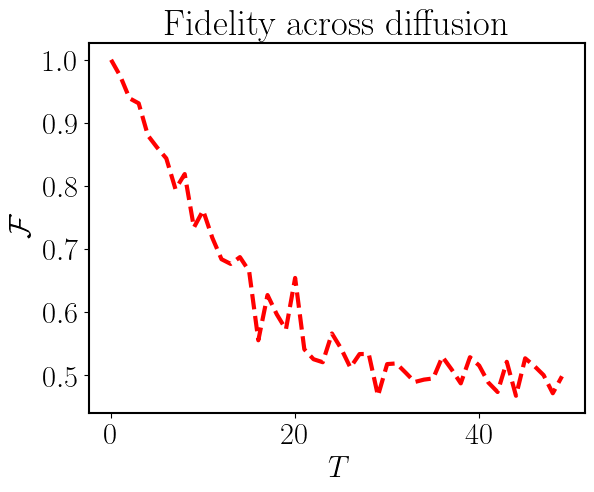

In [58]:
# visualize the decay of the fidelity as the diffusion proceeds

arr = compute_fidelity(Xout)
plt.plot(arr,"--r",linewidth=3)
plt.xlabel(r'$T$')
plt.ylabel(r'$\mathcal{F}$')
plt.title('Fidelity across diffusion')
plt.show()
plt.close()

## visualize the diffusion on the Bloch sphere

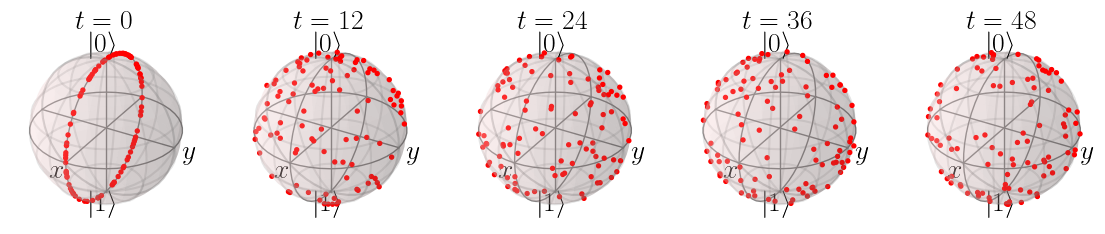

In [61]:
fig, axs = matplotlib.pyplot.subplots(1,5, figsize=(14,10), subplot_kw={'projection': '3d'})
cc = 0
indices = np.random.choice(Ndata, Ndata, replace=False)
diff_states = Xout[:,indices]
for i in range(0, T+1, 12):
    xs0, ys0, zs0 = bloch_xyz(diff_states[i])
    b0 = Bloch(fig=fig, axes=axs[cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['r']*Ndata
    b0.point_style = 'm'
    b0.point_size = 8*np.ones(Ndata)
    b0.render()
    axs[cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1



## Main training function for the model

In [62]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = WassDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [63]:
# denoise training

na = 2 # number of ancilla qubits
L = 7 # layer of backward PQC
epochs = 2001 # number of training epochs

# generate random samples at step t=T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)

# load diffusion process
states_diff = Xout
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)
params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T,epochs))

for t in tqdm(range(T-1, -1, -1)):
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs) #train the PQC at t, store the results in params_tot, and then 
    params_tot[t] = (params).detach().numpy()                                     # train at t - 1, and so on
    loss_tot[t] = (loss_hist).detach().numpy() 

  0%|          | 0/50 [00:00<?, ?it/s]

Step 0, loss: tensor(0.0437, grad_fn=<ValFunctionBackward>), time elapsed: 0.13552498817443848 seconds
Step 100, loss: tensor(0.0333, grad_fn=<ValFunctionBackward>), time elapsed: 3.896392822265625 seconds
Step 200, loss: tensor(0.0272, grad_fn=<ValFunctionBackward>), time elapsed: 6.140888929367065 seconds
Step 300, loss: tensor(0.0250, grad_fn=<ValFunctionBackward>), time elapsed: 9.003990888595581 seconds
Step 400, loss: tensor(0.0243, grad_fn=<ValFunctionBackward>), time elapsed: 13.658046960830688 seconds
Step 500, loss: tensor(0.0221, grad_fn=<ValFunctionBackward>), time elapsed: 16.96661901473999 seconds
Step 600, loss: tensor(0.0207, grad_fn=<ValFunctionBackward>), time elapsed: 21.2461040019989 seconds
Step 700, loss: tensor(0.0177, grad_fn=<ValFunctionBackward>), time elapsed: 25.66946291923523 seconds
Step 800, loss: tensor(0.0178, grad_fn=<ValFunctionBackward>), time elapsed: 28.589094877243042 seconds
Step 900, loss: tensor(0.0169, grad_fn=<ValFunctionBackward>), time elap

  2%|▏         | 1/50 [01:14<1:00:27, 74.04s/it]

Step 0, loss: tensor(0.1455, grad_fn=<ValFunctionBackward>), time elapsed: 0.028990983963012695 seconds
Step 100, loss: tensor(0.0570, grad_fn=<ValFunctionBackward>), time elapsed: 2.5517377853393555 seconds
Step 200, loss: tensor(0.0507, grad_fn=<ValFunctionBackward>), time elapsed: 5.139992952346802 seconds
Step 300, loss: tensor(0.0407, grad_fn=<ValFunctionBackward>), time elapsed: 9.380404949188232 seconds
Step 400, loss: tensor(0.0321, grad_fn=<ValFunctionBackward>), time elapsed: 13.950623035430908 seconds
Step 500, loss: tensor(0.0222, grad_fn=<ValFunctionBackward>), time elapsed: 16.71601176261902 seconds
Step 600, loss: tensor(0.0244, grad_fn=<ValFunctionBackward>), time elapsed: 20.58353066444397 seconds
Step 700, loss: tensor(0.0273, grad_fn=<ValFunctionBackward>), time elapsed: 22.709150075912476 seconds
Step 800, loss: tensor(0.0239, grad_fn=<ValFunctionBackward>), time elapsed: 25.832961797714233 seconds
Step 900, loss: tensor(0.0187, grad_fn=<ValFunctionBackward>), time 

  4%|▍         | 2/50 [02:22<56:30, 70.65s/it]  

Step 0, loss: tensor(0.1163, grad_fn=<ValFunctionBackward>), time elapsed: 0.04613304138183594 seconds
Step 100, loss: tensor(0.0551, grad_fn=<ValFunctionBackward>), time elapsed: 4.5175721645355225 seconds
Step 200, loss: tensor(0.0471, grad_fn=<ValFunctionBackward>), time elapsed: 6.934605121612549 seconds
Step 300, loss: tensor(0.0303, grad_fn=<ValFunctionBackward>), time elapsed: 9.918102025985718 seconds
Step 400, loss: tensor(0.0291, grad_fn=<ValFunctionBackward>), time elapsed: 12.983763217926025 seconds
Step 500, loss: tensor(0.0252, grad_fn=<ValFunctionBackward>), time elapsed: 15.588942050933838 seconds
Step 600, loss: tensor(0.0206, grad_fn=<ValFunctionBackward>), time elapsed: 22.492693185806274 seconds
Step 700, loss: tensor(0.0206, grad_fn=<ValFunctionBackward>), time elapsed: 26.641382217407227 seconds
Step 800, loss: tensor(0.0228, grad_fn=<ValFunctionBackward>), time elapsed: 30.26039695739746 seconds
Step 900, loss: tensor(0.0206, grad_fn=<ValFunctionBackward>), time 

  6%|▌         | 3/50 [03:57<1:04:12, 81.97s/it]

Step 0, loss: tensor(0.0721, grad_fn=<ValFunctionBackward>), time elapsed: 0.029814958572387695 seconds
Step 100, loss: tensor(0.0217, grad_fn=<ValFunctionBackward>), time elapsed: 2.4944369792938232 seconds
Step 200, loss: tensor(0.0210, grad_fn=<ValFunctionBackward>), time elapsed: 6.299779176712036 seconds
Step 300, loss: tensor(0.0198, grad_fn=<ValFunctionBackward>), time elapsed: 9.68831491470337 seconds
Step 400, loss: tensor(0.0241, grad_fn=<ValFunctionBackward>), time elapsed: 11.965776920318604 seconds
Step 500, loss: tensor(0.0235, grad_fn=<ValFunctionBackward>), time elapsed: 15.163917064666748 seconds
Step 600, loss: tensor(0.0196, grad_fn=<ValFunctionBackward>), time elapsed: 17.377459049224854 seconds
Step 700, loss: tensor(0.0202, grad_fn=<ValFunctionBackward>), time elapsed: 19.961127042770386 seconds
Step 800, loss: tensor(0.0163, grad_fn=<ValFunctionBackward>), time elapsed: 23.680511951446533 seconds
Step 900, loss: tensor(0.0212, grad_fn=<ValFunctionBackward>), time

  8%|▊         | 4/50 [05:04<58:22, 76.14s/it]  

Step 0, loss: tensor(0.0913, grad_fn=<ValFunctionBackward>), time elapsed: 0.03884434700012207 seconds
Step 100, loss: tensor(0.0610, grad_fn=<ValFunctionBackward>), time elapsed: 3.1058380603790283 seconds
Step 200, loss: tensor(0.0372, grad_fn=<ValFunctionBackward>), time elapsed: 5.707942247390747 seconds
Step 300, loss: tensor(0.0297, grad_fn=<ValFunctionBackward>), time elapsed: 8.872511148452759 seconds
Step 400, loss: tensor(0.0337, grad_fn=<ValFunctionBackward>), time elapsed: 12.36423397064209 seconds
Step 500, loss: tensor(0.0335, grad_fn=<ValFunctionBackward>), time elapsed: 15.907268285751343 seconds
Step 600, loss: tensor(0.0317, grad_fn=<ValFunctionBackward>), time elapsed: 18.547513246536255 seconds
Step 700, loss: tensor(0.0227, grad_fn=<ValFunctionBackward>), time elapsed: 22.91634511947632 seconds
Step 800, loss: tensor(0.0260, grad_fn=<ValFunctionBackward>), time elapsed: 28.056563138961792 seconds
Step 900, loss: tensor(0.0221, grad_fn=<ValFunctionBackward>), time e

 10%|█         | 5/50 [06:14<55:13, 73.63s/it]

Step 0, loss: tensor(0.0862, grad_fn=<ValFunctionBackward>), time elapsed: 0.04402470588684082 seconds
Step 100, loss: tensor(0.0667, grad_fn=<ValFunctionBackward>), time elapsed: 3.17545485496521 seconds
Step 200, loss: tensor(0.0373, grad_fn=<ValFunctionBackward>), time elapsed: 5.345771789550781 seconds
Step 300, loss: tensor(0.0337, grad_fn=<ValFunctionBackward>), time elapsed: 7.7652857303619385 seconds
Step 400, loss: tensor(0.0264, grad_fn=<ValFunctionBackward>), time elapsed: 10.66824984550476 seconds
Step 500, loss: tensor(0.0203, grad_fn=<ValFunctionBackward>), time elapsed: 13.575289726257324 seconds
Step 600, loss: tensor(0.0188, grad_fn=<ValFunctionBackward>), time elapsed: 15.813560724258423 seconds
Step 700, loss: tensor(0.0191, grad_fn=<ValFunctionBackward>), time elapsed: 18.41243600845337 seconds
Step 800, loss: tensor(0.0270, grad_fn=<ValFunctionBackward>), time elapsed: 20.827492713928223 seconds
Step 900, loss: tensor(0.0237, grad_fn=<ValFunctionBackward>), time el

 12%|█▏        | 6/50 [07:29<54:21, 74.13s/it]

Step 0, loss: tensor(0.1182, grad_fn=<ValFunctionBackward>), time elapsed: 0.03707385063171387 seconds
Step 100, loss: tensor(0.0559, grad_fn=<ValFunctionBackward>), time elapsed: 3.621901035308838 seconds
Step 200, loss: tensor(0.0589, grad_fn=<ValFunctionBackward>), time elapsed: 6.584551811218262 seconds
Step 300, loss: tensor(0.0278, grad_fn=<ValFunctionBackward>), time elapsed: 10.847030878067017 seconds
Step 400, loss: tensor(0.0333, grad_fn=<ValFunctionBackward>), time elapsed: 13.548244953155518 seconds
Step 500, loss: tensor(0.0197, grad_fn=<ValFunctionBackward>), time elapsed: 20.664272785186768 seconds
Step 600, loss: tensor(0.0189, grad_fn=<ValFunctionBackward>), time elapsed: 24.04542899131775 seconds
Step 700, loss: tensor(0.0209, grad_fn=<ValFunctionBackward>), time elapsed: 26.25173592567444 seconds
Step 800, loss: tensor(0.0259, grad_fn=<ValFunctionBackward>), time elapsed: 28.372179746627808 seconds
Step 900, loss: tensor(0.0188, grad_fn=<ValFunctionBackward>), time e

 14%|█▍        | 7/50 [08:39<52:07, 72.73s/it]

Step 0, loss: tensor(0.1314, grad_fn=<ValFunctionBackward>), time elapsed: 0.03245210647583008 seconds
Step 100, loss: tensor(0.0760, grad_fn=<ValFunctionBackward>), time elapsed: 3.7032902240753174 seconds
Step 200, loss: tensor(0.0604, grad_fn=<ValFunctionBackward>), time elapsed: 6.0874152183532715 seconds
Step 300, loss: tensor(0.0281, grad_fn=<ValFunctionBackward>), time elapsed: 8.753414154052734 seconds
Step 400, loss: tensor(0.0241, grad_fn=<ValFunctionBackward>), time elapsed: 12.10297703742981 seconds
Step 500, loss: tensor(0.0229, grad_fn=<ValFunctionBackward>), time elapsed: 14.625165224075317 seconds
Step 600, loss: tensor(0.0193, grad_fn=<ValFunctionBackward>), time elapsed: 16.91789221763611 seconds
Step 700, loss: tensor(0.0298, grad_fn=<ValFunctionBackward>), time elapsed: 18.959927082061768 seconds
Step 800, loss: tensor(0.0243, grad_fn=<ValFunctionBackward>), time elapsed: 21.517470121383667 seconds
Step 900, loss: tensor(0.0218, grad_fn=<ValFunctionBackward>), time 

 16%|█▌        | 8/50 [09:36<47:27, 67.81s/it]

Step 0, loss: tensor(0.0358, grad_fn=<ValFunctionBackward>), time elapsed: 0.025964975357055664 seconds
Step 100, loss: tensor(0.0368, grad_fn=<ValFunctionBackward>), time elapsed: 2.2036869525909424 seconds
Step 200, loss: tensor(0.0297, grad_fn=<ValFunctionBackward>), time elapsed: 4.181117057800293 seconds
Step 300, loss: tensor(0.0213, grad_fn=<ValFunctionBackward>), time elapsed: 6.266956090927124 seconds
Step 400, loss: tensor(0.0206, grad_fn=<ValFunctionBackward>), time elapsed: 9.172720909118652 seconds
Step 500, loss: tensor(0.0224, grad_fn=<ValFunctionBackward>), time elapsed: 11.35761308670044 seconds
Step 600, loss: tensor(0.0195, grad_fn=<ValFunctionBackward>), time elapsed: 13.431232929229736 seconds
Step 700, loss: tensor(0.0268, grad_fn=<ValFunctionBackward>), time elapsed: 15.643947124481201 seconds
Step 800, loss: tensor(0.0174, grad_fn=<ValFunctionBackward>), time elapsed: 17.6851589679718 seconds
Step 900, loss: tensor(0.0186, grad_fn=<ValFunctionBackward>), time el

 18%|█▊        | 9/50 [10:29<43:07, 63.11s/it]

Step 0, loss: tensor(0.0450, grad_fn=<ValFunctionBackward>), time elapsed: 0.0325617790222168 seconds
Step 100, loss: tensor(0.0354, grad_fn=<ValFunctionBackward>), time elapsed: 3.00754976272583 seconds
Step 200, loss: tensor(0.0238, grad_fn=<ValFunctionBackward>), time elapsed: 5.936527729034424 seconds
Step 300, loss: tensor(0.0287, grad_fn=<ValFunctionBackward>), time elapsed: 8.872802019119263 seconds
Step 400, loss: tensor(0.0254, grad_fn=<ValFunctionBackward>), time elapsed: 11.923118114471436 seconds
Step 500, loss: tensor(0.0202, grad_fn=<ValFunctionBackward>), time elapsed: 14.150799751281738 seconds
Step 600, loss: tensor(0.0238, grad_fn=<ValFunctionBackward>), time elapsed: 16.971773862838745 seconds
Step 700, loss: tensor(0.0187, grad_fn=<ValFunctionBackward>), time elapsed: 19.468506813049316 seconds
Step 800, loss: tensor(0.0161, grad_fn=<ValFunctionBackward>), time elapsed: 21.664258003234863 seconds
Step 900, loss: tensor(0.0180, grad_fn=<ValFunctionBackward>), time el

 20%|██        | 10/50 [11:22<40:02, 60.07s/it]

Step 0, loss: tensor(0.1726, grad_fn=<ValFunctionBackward>), time elapsed: 0.02422928810119629 seconds
Step 100, loss: tensor(0.0893, grad_fn=<ValFunctionBackward>), time elapsed: 2.3224220275878906 seconds
Step 200, loss: tensor(0.0634, grad_fn=<ValFunctionBackward>), time elapsed: 4.488424062728882 seconds
Step 300, loss: tensor(0.0363, grad_fn=<ValFunctionBackward>), time elapsed: 7.365584135055542 seconds
Step 400, loss: tensor(0.0270, grad_fn=<ValFunctionBackward>), time elapsed: 9.520200967788696 seconds
Step 500, loss: tensor(0.0290, grad_fn=<ValFunctionBackward>), time elapsed: 11.79661226272583 seconds
Step 600, loss: tensor(0.0284, grad_fn=<ValFunctionBackward>), time elapsed: 14.027307033538818 seconds
Step 700, loss: tensor(0.0231, grad_fn=<ValFunctionBackward>), time elapsed: 16.14987015724182 seconds
Step 800, loss: tensor(0.0226, grad_fn=<ValFunctionBackward>), time elapsed: 18.424439191818237 seconds
Step 900, loss: tensor(0.0260, grad_fn=<ValFunctionBackward>), time el

 22%|██▏       | 11/50 [12:12<37:06, 57.10s/it]

Step 0, loss: tensor(0.1656, grad_fn=<ValFunctionBackward>), time elapsed: 0.02632927894592285 seconds
Step 100, loss: tensor(0.1165, grad_fn=<ValFunctionBackward>), time elapsed: 2.328808069229126 seconds
Step 200, loss: tensor(0.0548, grad_fn=<ValFunctionBackward>), time elapsed: 4.481020927429199 seconds
Step 300, loss: tensor(0.0422, grad_fn=<ValFunctionBackward>), time elapsed: 7.480353116989136 seconds
Step 400, loss: tensor(0.0401, grad_fn=<ValFunctionBackward>), time elapsed: 9.589507818222046 seconds
Step 500, loss: tensor(0.0421, grad_fn=<ValFunctionBackward>), time elapsed: 11.83307409286499 seconds
Step 600, loss: tensor(0.0328, grad_fn=<ValFunctionBackward>), time elapsed: 14.20838212966919 seconds
Step 700, loss: tensor(0.0293, grad_fn=<ValFunctionBackward>), time elapsed: 16.36920714378357 seconds
Step 800, loss: tensor(0.0306, grad_fn=<ValFunctionBackward>), time elapsed: 18.550358057022095 seconds
Step 900, loss: tensor(0.0222, grad_fn=<ValFunctionBackward>), time elap

 24%|██▍       | 12/50 [13:04<35:11, 55.58s/it]

Step 0, loss: tensor(0.1780, grad_fn=<ValFunctionBackward>), time elapsed: 0.02273273468017578 seconds
Step 100, loss: tensor(0.0937, grad_fn=<ValFunctionBackward>), time elapsed: 2.647739887237549 seconds
Step 200, loss: tensor(0.0477, grad_fn=<ValFunctionBackward>), time elapsed: 4.893118858337402 seconds
Step 300, loss: tensor(0.0556, grad_fn=<ValFunctionBackward>), time elapsed: 8.147202730178833 seconds
Step 400, loss: tensor(0.0276, grad_fn=<ValFunctionBackward>), time elapsed: 10.272746801376343 seconds
Step 500, loss: tensor(0.0322, grad_fn=<ValFunctionBackward>), time elapsed: 12.623356819152832 seconds
Step 600, loss: tensor(0.0270, grad_fn=<ValFunctionBackward>), time elapsed: 15.024194717407227 seconds
Step 700, loss: tensor(0.0217, grad_fn=<ValFunctionBackward>), time elapsed: 17.19673490524292 seconds
Step 800, loss: tensor(0.0255, grad_fn=<ValFunctionBackward>), time elapsed: 19.6524395942688 seconds
Step 900, loss: tensor(0.0237, grad_fn=<ValFunctionBackward>), time ela

 26%|██▌       | 13/50 [13:59<34:05, 55.29s/it]

Step 0, loss: tensor(0.1061, grad_fn=<ValFunctionBackward>), time elapsed: 0.03604698181152344 seconds
Step 100, loss: tensor(0.0591, grad_fn=<ValFunctionBackward>), time elapsed: 2.4753520488739014 seconds
Step 200, loss: tensor(0.0549, grad_fn=<ValFunctionBackward>), time elapsed: 5.561721086502075 seconds
Step 300, loss: tensor(0.0305, grad_fn=<ValFunctionBackward>), time elapsed: 7.912897109985352 seconds
Step 400, loss: tensor(0.0290, grad_fn=<ValFunctionBackward>), time elapsed: 10.471857070922852 seconds
Step 500, loss: tensor(0.0267, grad_fn=<ValFunctionBackward>), time elapsed: 13.306542158126831 seconds
Step 600, loss: tensor(0.0290, grad_fn=<ValFunctionBackward>), time elapsed: 15.447557926177979 seconds
Step 700, loss: tensor(0.0218, grad_fn=<ValFunctionBackward>), time elapsed: 17.945358276367188 seconds
Step 800, loss: tensor(0.0189, grad_fn=<ValFunctionBackward>), time elapsed: 20.522910118103027 seconds
Step 900, loss: tensor(0.0189, grad_fn=<ValFunctionBackward>), time

 28%|██▊       | 14/50 [15:01<34:23, 57.31s/it]

Step 0, loss: tensor(0.0786, grad_fn=<ValFunctionBackward>), time elapsed: 0.05164003372192383 seconds
Step 100, loss: tensor(0.0310, grad_fn=<ValFunctionBackward>), time elapsed: 4.569930076599121 seconds
Step 200, loss: tensor(0.0215, grad_fn=<ValFunctionBackward>), time elapsed: 9.370814323425293 seconds
Step 300, loss: tensor(0.0247, grad_fn=<ValFunctionBackward>), time elapsed: 12.644399166107178 seconds
Step 400, loss: tensor(0.0214, grad_fn=<ValFunctionBackward>), time elapsed: 15.124258041381836 seconds
Step 500, loss: tensor(0.0197, grad_fn=<ValFunctionBackward>), time elapsed: 17.75889301300049 seconds
Step 600, loss: tensor(0.0204, grad_fn=<ValFunctionBackward>), time elapsed: 21.23850703239441 seconds
Step 700, loss: tensor(0.0221, grad_fn=<ValFunctionBackward>), time elapsed: 24.738256216049194 seconds
Step 800, loss: tensor(0.0190, grad_fn=<ValFunctionBackward>), time elapsed: 29.14020013809204 seconds
Step 900, loss: tensor(0.0171, grad_fn=<ValFunctionBackward>), time el

 30%|███       | 15/50 [16:05<34:40, 59.45s/it]

Step 0, loss: tensor(0.1022, grad_fn=<ValFunctionBackward>), time elapsed: 0.024016857147216797 seconds
Step 100, loss: tensor(0.0563, grad_fn=<ValFunctionBackward>), time elapsed: 2.984311819076538 seconds
Step 200, loss: tensor(0.0365, grad_fn=<ValFunctionBackward>), time elapsed: 5.27013373374939 seconds
Step 300, loss: tensor(0.0292, grad_fn=<ValFunctionBackward>), time elapsed: 7.687871932983398 seconds
Step 400, loss: tensor(0.0171, grad_fn=<ValFunctionBackward>), time elapsed: 9.997094869613647 seconds
Step 500, loss: tensor(0.0201, grad_fn=<ValFunctionBackward>), time elapsed: 12.190756797790527 seconds
Step 600, loss: tensor(0.0231, grad_fn=<ValFunctionBackward>), time elapsed: 14.447679042816162 seconds
Step 700, loss: tensor(0.0213, grad_fn=<ValFunctionBackward>), time elapsed: 16.600627899169922 seconds
Step 800, loss: tensor(0.0222, grad_fn=<ValFunctionBackward>), time elapsed: 19.59442901611328 seconds
Step 900, loss: tensor(0.0261, grad_fn=<ValFunctionBackward>), time el

 32%|███▏      | 16/50 [16:56<32:15, 56.92s/it]

Step 0, loss: tensor(0.0882, grad_fn=<ValFunctionBackward>), time elapsed: 0.02631664276123047 seconds
Step 100, loss: tensor(0.0474, grad_fn=<ValFunctionBackward>), time elapsed: 3.451387882232666 seconds
Step 200, loss: tensor(0.0287, grad_fn=<ValFunctionBackward>), time elapsed: 5.559516906738281 seconds
Step 300, loss: tensor(0.0252, grad_fn=<ValFunctionBackward>), time elapsed: 7.970433712005615 seconds
Step 400, loss: tensor(0.0239, grad_fn=<ValFunctionBackward>), time elapsed: 10.323092937469482 seconds
Step 500, loss: tensor(0.0236, grad_fn=<ValFunctionBackward>), time elapsed: 12.628811597824097 seconds
Step 600, loss: tensor(0.0267, grad_fn=<ValFunctionBackward>), time elapsed: 15.454214811325073 seconds
Step 700, loss: tensor(0.0232, grad_fn=<ValFunctionBackward>), time elapsed: 17.917635679244995 seconds
Step 800, loss: tensor(0.0182, grad_fn=<ValFunctionBackward>), time elapsed: 21.238719940185547 seconds
Step 900, loss: tensor(0.0206, grad_fn=<ValFunctionBackward>), time 

 34%|███▍      | 17/50 [17:52<31:00, 56.39s/it]

Step 0, loss: tensor(0.0620, grad_fn=<ValFunctionBackward>), time elapsed: 0.03558492660522461 seconds
Step 100, loss: tensor(0.0375, grad_fn=<ValFunctionBackward>), time elapsed: 3.4648139476776123 seconds
Step 200, loss: tensor(0.0206, grad_fn=<ValFunctionBackward>), time elapsed: 5.570676803588867 seconds
Step 300, loss: tensor(0.0265, grad_fn=<ValFunctionBackward>), time elapsed: 7.846850872039795 seconds
Step 400, loss: tensor(0.0248, grad_fn=<ValFunctionBackward>), time elapsed: 10.118015766143799 seconds
Step 500, loss: tensor(0.0205, grad_fn=<ValFunctionBackward>), time elapsed: 12.256546974182129 seconds
Step 600, loss: tensor(0.0234, grad_fn=<ValFunctionBackward>), time elapsed: 14.50019097328186 seconds
Step 700, loss: tensor(0.0233, grad_fn=<ValFunctionBackward>), time elapsed: 17.27204179763794 seconds
Step 800, loss: tensor(0.0220, grad_fn=<ValFunctionBackward>), time elapsed: 19.642961025238037 seconds
Step 900, loss: tensor(0.0220, grad_fn=<ValFunctionBackward>), time e

 36%|███▌      | 18/50 [18:44<29:27, 55.25s/it]

Step 0, loss: tensor(0.0476, grad_fn=<ValFunctionBackward>), time elapsed: 0.02473926544189453 seconds
Step 100, loss: tensor(0.0264, grad_fn=<ValFunctionBackward>), time elapsed: 2.306288003921509 seconds
Step 200, loss: tensor(0.0235, grad_fn=<ValFunctionBackward>), time elapsed: 4.423161029815674 seconds
Step 300, loss: tensor(0.0216, grad_fn=<ValFunctionBackward>), time elapsed: 6.773030042648315 seconds
Step 400, loss: tensor(0.0202, grad_fn=<ValFunctionBackward>), time elapsed: 8.939249038696289 seconds
Step 500, loss: tensor(0.0210, grad_fn=<ValFunctionBackward>), time elapsed: 11.17282223701477 seconds
Step 600, loss: tensor(0.0195, grad_fn=<ValFunctionBackward>), time elapsed: 13.29811692237854 seconds
Step 700, loss: tensor(0.0232, grad_fn=<ValFunctionBackward>), time elapsed: 16.184592962265015 seconds
Step 800, loss: tensor(0.0291, grad_fn=<ValFunctionBackward>), time elapsed: 18.270292043685913 seconds
Step 900, loss: tensor(0.0201, grad_fn=<ValFunctionBackward>), time ela

 38%|███▊      | 19/50 [19:41<28:50, 55.83s/it]

Step 0, loss: tensor(0.0932, grad_fn=<ValFunctionBackward>), time elapsed: 0.026406049728393555 seconds
Step 100, loss: tensor(0.0441, grad_fn=<ValFunctionBackward>), time elapsed: 2.273754119873047 seconds
Step 200, loss: tensor(0.0335, grad_fn=<ValFunctionBackward>), time elapsed: 4.566617012023926 seconds
Step 300, loss: tensor(0.0253, grad_fn=<ValFunctionBackward>), time elapsed: 6.601702928543091 seconds
Step 400, loss: tensor(0.0251, grad_fn=<ValFunctionBackward>), time elapsed: 8.815576076507568 seconds
Step 500, loss: tensor(0.0253, grad_fn=<ValFunctionBackward>), time elapsed: 10.83291220664978 seconds
Step 600, loss: tensor(0.0240, grad_fn=<ValFunctionBackward>), time elapsed: 13.73376202583313 seconds
Step 700, loss: tensor(0.0254, grad_fn=<ValFunctionBackward>), time elapsed: 15.905395030975342 seconds
Step 800, loss: tensor(0.0249, grad_fn=<ValFunctionBackward>), time elapsed: 17.90900707244873 seconds
Step 900, loss: tensor(0.0224, grad_fn=<ValFunctionBackward>), time ela

 40%|████      | 20/50 [20:38<28:03, 56.12s/it]

Step 0, loss: tensor(0.0679, grad_fn=<ValFunctionBackward>), time elapsed: 0.03567910194396973 seconds
Step 100, loss: tensor(0.0462, grad_fn=<ValFunctionBackward>), time elapsed: 3.642360210418701 seconds
Step 200, loss: tensor(0.0308, grad_fn=<ValFunctionBackward>), time elapsed: 5.923427104949951 seconds
Step 300, loss: tensor(0.0249, grad_fn=<ValFunctionBackward>), time elapsed: 10.567665338516235 seconds
Step 400, loss: tensor(0.0245, grad_fn=<ValFunctionBackward>), time elapsed: 13.771483182907104 seconds
Step 500, loss: tensor(0.0238, grad_fn=<ValFunctionBackward>), time elapsed: 16.216564178466797 seconds
Step 600, loss: tensor(0.0201, grad_fn=<ValFunctionBackward>), time elapsed: 19.9507052898407 seconds
Step 700, loss: tensor(0.0236, grad_fn=<ValFunctionBackward>), time elapsed: 22.209338188171387 seconds
Step 800, loss: tensor(0.0212, grad_fn=<ValFunctionBackward>), time elapsed: 24.67110300064087 seconds
Step 900, loss: tensor(0.0234, grad_fn=<ValFunctionBackward>), time el

 42%|████▏     | 21/50 [21:38<27:42, 57.33s/it]

Step 0, loss: tensor(0.0451, grad_fn=<ValFunctionBackward>), time elapsed: 0.028255939483642578 seconds
Step 100, loss: tensor(0.0334, grad_fn=<ValFunctionBackward>), time elapsed: 2.3200249671936035 seconds
Step 200, loss: tensor(0.0242, grad_fn=<ValFunctionBackward>), time elapsed: 4.41299295425415 seconds
Step 300, loss: tensor(0.0260, grad_fn=<ValFunctionBackward>), time elapsed: 6.750513792037964 seconds
Step 400, loss: tensor(0.0175, grad_fn=<ValFunctionBackward>), time elapsed: 8.929210901260376 seconds
Step 500, loss: tensor(0.0178, grad_fn=<ValFunctionBackward>), time elapsed: 11.25818395614624 seconds
Step 600, loss: tensor(0.0175, grad_fn=<ValFunctionBackward>), time elapsed: 14.584560871124268 seconds
Step 700, loss: tensor(0.0236, grad_fn=<ValFunctionBackward>), time elapsed: 16.73599100112915 seconds
Step 800, loss: tensor(0.0179, grad_fn=<ValFunctionBackward>), time elapsed: 18.95602774620056 seconds
Step 900, loss: tensor(0.0287, grad_fn=<ValFunctionBackward>), time ela

 44%|████▍     | 22/50 [22:31<26:09, 56.05s/it]

Step 0, loss: tensor(0.1605, grad_fn=<ValFunctionBackward>), time elapsed: 0.030237913131713867 seconds
Step 100, loss: tensor(0.0814, grad_fn=<ValFunctionBackward>), time elapsed: 2.360046148300171 seconds
Step 200, loss: tensor(0.0602, grad_fn=<ValFunctionBackward>), time elapsed: 4.512346267700195 seconds
Step 300, loss: tensor(0.0284, grad_fn=<ValFunctionBackward>), time elapsed: 6.776523113250732 seconds
Step 400, loss: tensor(0.0379, grad_fn=<ValFunctionBackward>), time elapsed: 8.997653007507324 seconds
Step 500, loss: tensor(0.0301, grad_fn=<ValFunctionBackward>), time elapsed: 12.013782024383545 seconds
Step 600, loss: tensor(0.0346, grad_fn=<ValFunctionBackward>), time elapsed: 14.174883127212524 seconds
Step 700, loss: tensor(0.0286, grad_fn=<ValFunctionBackward>), time elapsed: 16.787248134613037 seconds
Step 800, loss: tensor(0.0189, grad_fn=<ValFunctionBackward>), time elapsed: 19.421805143356323 seconds
Step 900, loss: tensor(0.0227, grad_fn=<ValFunctionBackward>), time 

 46%|████▌     | 23/50 [23:23<24:35, 54.64s/it]

Step 0, loss: tensor(0.1454, grad_fn=<ValFunctionBackward>), time elapsed: 0.025944232940673828 seconds
Step 100, loss: tensor(0.0874, grad_fn=<ValFunctionBackward>), time elapsed: 2.466919183731079 seconds
Step 200, loss: tensor(0.0321, grad_fn=<ValFunctionBackward>), time elapsed: 4.7515482902526855 seconds
Step 300, loss: tensor(0.0333, grad_fn=<ValFunctionBackward>), time elapsed: 7.048312187194824 seconds
Step 400, loss: tensor(0.0241, grad_fn=<ValFunctionBackward>), time elapsed: 9.21901798248291 seconds
Step 500, loss: tensor(0.0258, grad_fn=<ValFunctionBackward>), time elapsed: 12.25579023361206 seconds
Step 600, loss: tensor(0.0250, grad_fn=<ValFunctionBackward>), time elapsed: 14.39877724647522 seconds
Step 700, loss: tensor(0.0186, grad_fn=<ValFunctionBackward>), time elapsed: 16.680889129638672 seconds
Step 800, loss: tensor(0.0200, grad_fn=<ValFunctionBackward>), time elapsed: 19.018498182296753 seconds
Step 900, loss: tensor(0.0214, grad_fn=<ValFunctionBackward>), time el

 48%|████▊     | 24/50 [24:16<23:32, 54.33s/it]

Step 0, loss: tensor(0.0479, grad_fn=<ValFunctionBackward>), time elapsed: 0.02527904510498047 seconds
Step 100, loss: tensor(0.0325, grad_fn=<ValFunctionBackward>), time elapsed: 2.828739881515503 seconds
Step 200, loss: tensor(0.0235, grad_fn=<ValFunctionBackward>), time elapsed: 4.969020128250122 seconds
Step 300, loss: tensor(0.0216, grad_fn=<ValFunctionBackward>), time elapsed: 7.233556032180786 seconds
Step 400, loss: tensor(0.0215, grad_fn=<ValFunctionBackward>), time elapsed: 10.052265167236328 seconds
Step 500, loss: tensor(0.0236, grad_fn=<ValFunctionBackward>), time elapsed: 12.306668996810913 seconds
Step 600, loss: tensor(0.0189, grad_fn=<ValFunctionBackward>), time elapsed: 14.368791818618774 seconds
Step 700, loss: tensor(0.0227, grad_fn=<ValFunctionBackward>), time elapsed: 16.57856297492981 seconds
Step 800, loss: tensor(0.0228, grad_fn=<ValFunctionBackward>), time elapsed: 18.790966033935547 seconds
Step 900, loss: tensor(0.0185, grad_fn=<ValFunctionBackward>), time e

 50%|█████     | 25/50 [25:05<21:59, 52.78s/it]

Step 0, loss: tensor(0.0524, grad_fn=<ValFunctionBackward>), time elapsed: 0.02395796775817871 seconds
Step 100, loss: tensor(0.0219, grad_fn=<ValFunctionBackward>), time elapsed: 2.3295998573303223 seconds
Step 200, loss: tensor(0.0207, grad_fn=<ValFunctionBackward>), time elapsed: 4.439091205596924 seconds
Step 300, loss: tensor(0.0238, grad_fn=<ValFunctionBackward>), time elapsed: 6.501404047012329 seconds
Step 400, loss: tensor(0.0244, grad_fn=<ValFunctionBackward>), time elapsed: 9.290644884109497 seconds
Step 500, loss: tensor(0.0263, grad_fn=<ValFunctionBackward>), time elapsed: 11.342408180236816 seconds
Step 600, loss: tensor(0.0233, grad_fn=<ValFunctionBackward>), time elapsed: 13.774827003479004 seconds
Step 700, loss: tensor(0.0244, grad_fn=<ValFunctionBackward>), time elapsed: 16.989548921585083 seconds
Step 800, loss: tensor(0.0200, grad_fn=<ValFunctionBackward>), time elapsed: 19.10737919807434 seconds
Step 900, loss: tensor(0.0214, grad_fn=<ValFunctionBackward>), time e

 52%|█████▏    | 26/50 [25:57<20:59, 52.49s/it]

Step 0, loss: tensor(0.0747, grad_fn=<ValFunctionBackward>), time elapsed: 0.03311419486999512 seconds
Step 100, loss: tensor(0.0312, grad_fn=<ValFunctionBackward>), time elapsed: 3.0946731567382812 seconds
Step 200, loss: tensor(0.0243, grad_fn=<ValFunctionBackward>), time elapsed: 5.445926189422607 seconds
Step 300, loss: tensor(0.0185, grad_fn=<ValFunctionBackward>), time elapsed: 8.714140892028809 seconds
Step 400, loss: tensor(0.0215, grad_fn=<ValFunctionBackward>), time elapsed: 11.303194999694824 seconds
Step 500, loss: tensor(0.0203, grad_fn=<ValFunctionBackward>), time elapsed: 13.470478057861328 seconds
Step 600, loss: tensor(0.0221, grad_fn=<ValFunctionBackward>), time elapsed: 15.993637084960938 seconds
Step 700, loss: tensor(0.0190, grad_fn=<ValFunctionBackward>), time elapsed: 18.515949964523315 seconds
Step 800, loss: tensor(0.0213, grad_fn=<ValFunctionBackward>), time elapsed: 20.66739511489868 seconds
Step 900, loss: tensor(0.0222, grad_fn=<ValFunctionBackward>), time 

 54%|█████▍    | 27/50 [26:52<20:22, 53.15s/it]

Step 0, loss: tensor(0.1602, grad_fn=<ValFunctionBackward>), time elapsed: 0.02726292610168457 seconds
Step 100, loss: tensor(0.0759, grad_fn=<ValFunctionBackward>), time elapsed: 2.267828941345215 seconds
Step 200, loss: tensor(0.0555, grad_fn=<ValFunctionBackward>), time elapsed: 4.3565919399261475 seconds
Step 300, loss: tensor(0.0346, grad_fn=<ValFunctionBackward>), time elapsed: 7.547652959823608 seconds
Step 400, loss: tensor(0.0318, grad_fn=<ValFunctionBackward>), time elapsed: 9.79194188117981 seconds
Step 500, loss: tensor(0.0242, grad_fn=<ValFunctionBackward>), time elapsed: 12.097425937652588 seconds
Step 600, loss: tensor(0.0283, grad_fn=<ValFunctionBackward>), time elapsed: 14.585976123809814 seconds
Step 700, loss: tensor(0.0219, grad_fn=<ValFunctionBackward>), time elapsed: 17.17248296737671 seconds
Step 800, loss: tensor(0.0254, grad_fn=<ValFunctionBackward>), time elapsed: 19.299035787582397 seconds
Step 900, loss: tensor(0.0228, grad_fn=<ValFunctionBackward>), time el

 56%|█████▌    | 28/50 [27:46<19:33, 53.36s/it]

Step 0, loss: tensor(0.0374, grad_fn=<ValFunctionBackward>), time elapsed: 0.0272829532623291 seconds
Step 100, loss: tensor(0.0411, grad_fn=<ValFunctionBackward>), time elapsed: 2.6957199573516846 seconds
Step 200, loss: tensor(0.0329, grad_fn=<ValFunctionBackward>), time elapsed: 6.071099042892456 seconds
Step 300, loss: tensor(0.0261, grad_fn=<ValFunctionBackward>), time elapsed: 8.680855989456177 seconds
Step 400, loss: tensor(0.0244, grad_fn=<ValFunctionBackward>), time elapsed: 11.190663814544678 seconds
Step 500, loss: tensor(0.0222, grad_fn=<ValFunctionBackward>), time elapsed: 14.04885196685791 seconds
Step 600, loss: tensor(0.0199, grad_fn=<ValFunctionBackward>), time elapsed: 16.75271701812744 seconds
Step 700, loss: tensor(0.0201, grad_fn=<ValFunctionBackward>), time elapsed: 19.315528869628906 seconds
Step 800, loss: tensor(0.0170, grad_fn=<ValFunctionBackward>), time elapsed: 21.904720067977905 seconds
Step 900, loss: tensor(0.0213, grad_fn=<ValFunctionBackward>), time el

 58%|█████▊    | 29/50 [28:49<19:42, 56.31s/it]

Step 0, loss: tensor(0.1422, grad_fn=<ValFunctionBackward>), time elapsed: 0.029928922653198242 seconds
Step 100, loss: tensor(0.0774, grad_fn=<ValFunctionBackward>), time elapsed: 2.2642171382904053 seconds
Step 200, loss: tensor(0.0390, grad_fn=<ValFunctionBackward>), time elapsed: 5.359436988830566 seconds
Step 300, loss: tensor(0.0297, grad_fn=<ValFunctionBackward>), time elapsed: 7.478880882263184 seconds
Step 400, loss: tensor(0.0251, grad_fn=<ValFunctionBackward>), time elapsed: 9.751869916915894 seconds
Step 500, loss: tensor(0.0245, grad_fn=<ValFunctionBackward>), time elapsed: 12.446717977523804 seconds
Step 600, loss: tensor(0.0185, grad_fn=<ValFunctionBackward>), time elapsed: 14.75884199142456 seconds
Step 700, loss: tensor(0.0208, grad_fn=<ValFunctionBackward>), time elapsed: 17.445034980773926 seconds
Step 800, loss: tensor(0.0203, grad_fn=<ValFunctionBackward>), time elapsed: 20.87533211708069 seconds
Step 900, loss: tensor(0.0179, grad_fn=<ValFunctionBackward>), time e

 60%|██████    | 30/50 [29:43<18:29, 55.47s/it]

Step 0, loss: tensor(0.1284, grad_fn=<ValFunctionBackward>), time elapsed: 0.03148508071899414 seconds
Step 100, loss: tensor(0.0536, grad_fn=<ValFunctionBackward>), time elapsed: 3.2701947689056396 seconds
Step 200, loss: tensor(0.0247, grad_fn=<ValFunctionBackward>), time elapsed: 5.462594985961914 seconds
Step 300, loss: tensor(0.0236, grad_fn=<ValFunctionBackward>), time elapsed: 7.813668966293335 seconds
Step 400, loss: tensor(0.0222, grad_fn=<ValFunctionBackward>), time elapsed: 10.156170845031738 seconds
Step 500, loss: tensor(0.0185, grad_fn=<ValFunctionBackward>), time elapsed: 12.414561986923218 seconds
Step 600, loss: tensor(0.0249, grad_fn=<ValFunctionBackward>), time elapsed: 14.726918935775757 seconds
Step 700, loss: tensor(0.0206, grad_fn=<ValFunctionBackward>), time elapsed: 17.230639934539795 seconds
Step 800, loss: tensor(0.0214, grad_fn=<ValFunctionBackward>), time elapsed: 20.54469084739685 seconds
Step 900, loss: tensor(0.0213, grad_fn=<ValFunctionBackward>), time 

 62%|██████▏   | 31/50 [30:48<18:30, 58.42s/it]

Step 0, loss: tensor(0.0531, grad_fn=<ValFunctionBackward>), time elapsed: 0.030230045318603516 seconds
Step 100, loss: tensor(0.0297, grad_fn=<ValFunctionBackward>), time elapsed: 3.723491907119751 seconds
Step 200, loss: tensor(0.0204, grad_fn=<ValFunctionBackward>), time elapsed: 5.972453832626343 seconds
Step 300, loss: tensor(0.0195, grad_fn=<ValFunctionBackward>), time elapsed: 8.34553599357605 seconds
Step 400, loss: tensor(0.0192, grad_fn=<ValFunctionBackward>), time elapsed: 10.7392897605896 seconds
Step 500, loss: tensor(0.0234, grad_fn=<ValFunctionBackward>), time elapsed: 13.461488962173462 seconds
Step 600, loss: tensor(0.0199, grad_fn=<ValFunctionBackward>), time elapsed: 16.131662845611572 seconds
Step 700, loss: tensor(0.0212, grad_fn=<ValFunctionBackward>), time elapsed: 19.002575874328613 seconds
Step 800, loss: tensor(0.0204, grad_fn=<ValFunctionBackward>), time elapsed: 21.71337604522705 seconds
Step 900, loss: tensor(0.0148, grad_fn=<ValFunctionBackward>), time ela

 64%|██████▍   | 32/50 [31:52<18:00, 60.05s/it]

Step 0, loss: tensor(0.0914, grad_fn=<ValFunctionBackward>), time elapsed: 0.0295259952545166 seconds
Step 100, loss: tensor(0.0650, grad_fn=<ValFunctionBackward>), time elapsed: 2.4211158752441406 seconds
Step 200, loss: tensor(0.0516, grad_fn=<ValFunctionBackward>), time elapsed: 4.5839879512786865 seconds
Step 300, loss: tensor(0.0326, grad_fn=<ValFunctionBackward>), time elapsed: 6.997091054916382 seconds
Step 400, loss: tensor(0.0256, grad_fn=<ValFunctionBackward>), time elapsed: 9.658974885940552 seconds
Step 500, loss: tensor(0.0257, grad_fn=<ValFunctionBackward>), time elapsed: 11.902256965637207 seconds
Step 600, loss: tensor(0.0213, grad_fn=<ValFunctionBackward>), time elapsed: 14.683670997619629 seconds
Step 700, loss: tensor(0.0268, grad_fn=<ValFunctionBackward>), time elapsed: 20.706918954849243 seconds
Step 800, loss: tensor(0.0234, grad_fn=<ValFunctionBackward>), time elapsed: 23.706235885620117 seconds
Step 900, loss: tensor(0.0261, grad_fn=<ValFunctionBackward>), time 

 66%|██████▌   | 33/50 [32:58<17:34, 62.01s/it]

Step 0, loss: tensor(0.1118, grad_fn=<ValFunctionBackward>), time elapsed: 0.03154397010803223 seconds
Step 100, loss: tensor(0.0625, grad_fn=<ValFunctionBackward>), time elapsed: 2.8012027740478516 seconds
Step 200, loss: tensor(0.0414, grad_fn=<ValFunctionBackward>), time elapsed: 4.863006830215454 seconds
Step 300, loss: tensor(0.0379, grad_fn=<ValFunctionBackward>), time elapsed: 7.2785868644714355 seconds
Step 400, loss: tensor(0.0237, grad_fn=<ValFunctionBackward>), time elapsed: 9.93242597579956 seconds
Step 500, loss: tensor(0.0218, grad_fn=<ValFunctionBackward>), time elapsed: 12.215480089187622 seconds
Step 600, loss: tensor(0.0185, grad_fn=<ValFunctionBackward>), time elapsed: 16.107515811920166 seconds
Step 700, loss: tensor(0.0187, grad_fn=<ValFunctionBackward>), time elapsed: 19.54562473297119 seconds
Step 800, loss: tensor(0.0206, grad_fn=<ValFunctionBackward>), time elapsed: 22.66656994819641 seconds
Step 900, loss: tensor(0.0207, grad_fn=<ValFunctionBackward>), time el

 68%|██████▊   | 34/50 [34:06<16:57, 63.58s/it]

Step 0, loss: tensor(0.1718, grad_fn=<ValFunctionBackward>), time elapsed: 0.04242110252380371 seconds
Step 100, loss: tensor(0.1106, grad_fn=<ValFunctionBackward>), time elapsed: 2.3072540760040283 seconds
Step 200, loss: tensor(0.0653, grad_fn=<ValFunctionBackward>), time elapsed: 4.628834009170532 seconds
Step 300, loss: tensor(0.0472, grad_fn=<ValFunctionBackward>), time elapsed: 6.7291789054870605 seconds
Step 400, loss: tensor(0.0278, grad_fn=<ValFunctionBackward>), time elapsed: 9.089668989181519 seconds
Step 500, loss: tensor(0.0220, grad_fn=<ValFunctionBackward>), time elapsed: 11.359133005142212 seconds
Step 600, loss: tensor(0.0329, grad_fn=<ValFunctionBackward>), time elapsed: 15.042500972747803 seconds
Step 700, loss: tensor(0.0228, grad_fn=<ValFunctionBackward>), time elapsed: 17.708664178848267 seconds
Step 800, loss: tensor(0.0210, grad_fn=<ValFunctionBackward>), time elapsed: 20.303564071655273 seconds
Step 900, loss: tensor(0.0182, grad_fn=<ValFunctionBackward>), time

 70%|███████   | 35/50 [35:07<15:45, 63.00s/it]

Step 0, loss: tensor(0.0803, grad_fn=<ValFunctionBackward>), time elapsed: 0.03312516212463379 seconds
Step 100, loss: tensor(0.0463, grad_fn=<ValFunctionBackward>), time elapsed: 2.9254231452941895 seconds
Step 200, loss: tensor(0.0311, grad_fn=<ValFunctionBackward>), time elapsed: 5.120124101638794 seconds
Step 300, loss: tensor(0.0229, grad_fn=<ValFunctionBackward>), time elapsed: 7.354526996612549 seconds
Step 400, loss: tensor(0.0215, grad_fn=<ValFunctionBackward>), time elapsed: 9.683377981185913 seconds
Step 500, loss: tensor(0.0267, grad_fn=<ValFunctionBackward>), time elapsed: 12.72360897064209 seconds
Step 600, loss: tensor(0.0231, grad_fn=<ValFunctionBackward>), time elapsed: 14.883400917053223 seconds
Step 700, loss: tensor(0.0204, grad_fn=<ValFunctionBackward>), time elapsed: 17.797597885131836 seconds
Step 800, loss: tensor(0.0282, grad_fn=<ValFunctionBackward>), time elapsed: 20.779686212539673 seconds
Step 900, loss: tensor(0.0188, grad_fn=<ValFunctionBackward>), time e

 72%|███████▏  | 36/50 [36:05<14:20, 61.49s/it]

Step 0, loss: tensor(0.1031, grad_fn=<ValFunctionBackward>), time elapsed: 0.023584842681884766 seconds
Step 100, loss: tensor(0.0648, grad_fn=<ValFunctionBackward>), time elapsed: 2.4435648918151855 seconds
Step 200, loss: tensor(0.0430, grad_fn=<ValFunctionBackward>), time elapsed: 4.73800802230835 seconds
Step 300, loss: tensor(0.0334, grad_fn=<ValFunctionBackward>), time elapsed: 7.423580884933472 seconds
Step 400, loss: tensor(0.0275, grad_fn=<ValFunctionBackward>), time elapsed: 10.654375791549683 seconds
Step 500, loss: tensor(0.0195, grad_fn=<ValFunctionBackward>), time elapsed: 13.75444507598877 seconds
Step 600, loss: tensor(0.0221, grad_fn=<ValFunctionBackward>), time elapsed: 16.01836585998535 seconds
Step 700, loss: tensor(0.0216, grad_fn=<ValFunctionBackward>), time elapsed: 19.028944730758667 seconds
Step 800, loss: tensor(0.0267, grad_fn=<ValFunctionBackward>), time elapsed: 21.514638900756836 seconds
Step 900, loss: tensor(0.0211, grad_fn=<ValFunctionBackward>), time e

 74%|███████▍  | 37/50 [37:05<13:12, 61.00s/it]

Step 0, loss: tensor(0.0416, grad_fn=<ValFunctionBackward>), time elapsed: 0.028215885162353516 seconds
Step 100, loss: tensor(0.0305, grad_fn=<ValFunctionBackward>), time elapsed: 2.3768250942230225 seconds
Step 200, loss: tensor(0.0267, grad_fn=<ValFunctionBackward>), time elapsed: 4.435533046722412 seconds
Step 300, loss: tensor(0.0164, grad_fn=<ValFunctionBackward>), time elapsed: 7.279420852661133 seconds
Step 400, loss: tensor(0.0258, grad_fn=<ValFunctionBackward>), time elapsed: 11.853430986404419 seconds
Step 500, loss: tensor(0.0198, grad_fn=<ValFunctionBackward>), time elapsed: 14.090842962265015 seconds
Step 600, loss: tensor(0.0165, grad_fn=<ValFunctionBackward>), time elapsed: 16.682868003845215 seconds
Step 700, loss: tensor(0.0183, grad_fn=<ValFunctionBackward>), time elapsed: 19.250843048095703 seconds
Step 800, loss: tensor(0.0223, grad_fn=<ValFunctionBackward>), time elapsed: 21.340646028518677 seconds
Step 900, loss: tensor(0.0189, grad_fn=<ValFunctionBackward>), tim

 76%|███████▌  | 38/50 [38:05<12:09, 60.80s/it]

Step 0, loss: tensor(0.0922, grad_fn=<ValFunctionBackward>), time elapsed: 0.03265523910522461 seconds
Step 100, loss: tensor(0.0681, grad_fn=<ValFunctionBackward>), time elapsed: 2.912119150161743 seconds
Step 200, loss: tensor(0.0339, grad_fn=<ValFunctionBackward>), time elapsed: 5.055845260620117 seconds
Step 300, loss: tensor(0.0499, grad_fn=<ValFunctionBackward>), time elapsed: 8.3840172290802 seconds
Step 400, loss: tensor(0.0306, grad_fn=<ValFunctionBackward>), time elapsed: 11.28803038597107 seconds
Step 500, loss: tensor(0.0261, grad_fn=<ValFunctionBackward>), time elapsed: 13.445000171661377 seconds
Step 600, loss: tensor(0.0257, grad_fn=<ValFunctionBackward>), time elapsed: 15.784363031387329 seconds
Step 700, loss: tensor(0.0237, grad_fn=<ValFunctionBackward>), time elapsed: 18.01871919631958 seconds
Step 800, loss: tensor(0.0233, grad_fn=<ValFunctionBackward>), time elapsed: 20.16022825241089 seconds
Step 900, loss: tensor(0.0160, grad_fn=<ValFunctionBackward>), time elaps

 78%|███████▊  | 39/50 [38:58<10:43, 58.48s/it]

Step 0, loss: tensor(0.0561, grad_fn=<ValFunctionBackward>), time elapsed: 0.028223037719726562 seconds
Step 100, loss: tensor(0.0338, grad_fn=<ValFunctionBackward>), time elapsed: 2.1495702266693115 seconds
Step 200, loss: tensor(0.0273, grad_fn=<ValFunctionBackward>), time elapsed: 4.6241888999938965 seconds
Step 300, loss: tensor(0.0183, grad_fn=<ValFunctionBackward>), time elapsed: 7.775933027267456 seconds
Step 400, loss: tensor(0.0239, grad_fn=<ValFunctionBackward>), time elapsed: 9.859911918640137 seconds
Step 500, loss: tensor(0.0205, grad_fn=<ValFunctionBackward>), time elapsed: 12.505221843719482 seconds
Step 600, loss: tensor(0.0225, grad_fn=<ValFunctionBackward>), time elapsed: 15.321320056915283 seconds
Step 700, loss: tensor(0.0188, grad_fn=<ValFunctionBackward>), time elapsed: 18.270836114883423 seconds
Step 800, loss: tensor(0.0268, grad_fn=<ValFunctionBackward>), time elapsed: 20.980565071105957 seconds
Step 900, loss: tensor(0.0174, grad_fn=<ValFunctionBackward>), tim

 80%|████████  | 40/50 [39:55<09:38, 57.83s/it]

Step 0, loss: tensor(0.1387, grad_fn=<ValFunctionBackward>), time elapsed: 0.03118419647216797 seconds
Step 100, loss: tensor(0.0878, grad_fn=<ValFunctionBackward>), time elapsed: 2.4891510009765625 seconds
Step 200, loss: tensor(0.0622, grad_fn=<ValFunctionBackward>), time elapsed: 5.504957914352417 seconds
Step 300, loss: tensor(0.0424, grad_fn=<ValFunctionBackward>), time elapsed: 7.733062028884888 seconds
Step 400, loss: tensor(0.0430, grad_fn=<ValFunctionBackward>), time elapsed: 9.745579957962036 seconds
Step 500, loss: tensor(0.0301, grad_fn=<ValFunctionBackward>), time elapsed: 11.995238065719604 seconds
Step 600, loss: tensor(0.0296, grad_fn=<ValFunctionBackward>), time elapsed: 14.21318006515503 seconds
Step 700, loss: tensor(0.0244, grad_fn=<ValFunctionBackward>), time elapsed: 16.61252498626709 seconds
Step 800, loss: tensor(0.0239, grad_fn=<ValFunctionBackward>), time elapsed: 18.731544017791748 seconds
Step 900, loss: tensor(0.0188, grad_fn=<ValFunctionBackward>), time el

 82%|████████▏ | 41/50 [40:47<08:24, 56.08s/it]

Step 0, loss: tensor(0.1986, grad_fn=<ValFunctionBackward>), time elapsed: 0.033200979232788086 seconds
Step 100, loss: tensor(0.0976, grad_fn=<ValFunctionBackward>), time elapsed: 3.223472833633423 seconds
Step 200, loss: tensor(0.0505, grad_fn=<ValFunctionBackward>), time elapsed: 5.3449437618255615 seconds
Step 300, loss: tensor(0.0329, grad_fn=<ValFunctionBackward>), time elapsed: 7.6415159702301025 seconds
Step 400, loss: tensor(0.0255, grad_fn=<ValFunctionBackward>), time elapsed: 9.610743999481201 seconds
Step 500, loss: tensor(0.0243, grad_fn=<ValFunctionBackward>), time elapsed: 12.056038856506348 seconds
Step 600, loss: tensor(0.0252, grad_fn=<ValFunctionBackward>), time elapsed: 14.20433497428894 seconds
Step 700, loss: tensor(0.0254, grad_fn=<ValFunctionBackward>), time elapsed: 16.709793090820312 seconds
Step 800, loss: tensor(0.0229, grad_fn=<ValFunctionBackward>), time elapsed: 19.76724410057068 seconds
Step 900, loss: tensor(0.0228, grad_fn=<ValFunctionBackward>), time 

 84%|████████▍ | 42/50 [41:43<07:28, 56.01s/it]

Step 0, loss: tensor(0.2331, grad_fn=<ValFunctionBackward>), time elapsed: 0.03057408332824707 seconds
Step 100, loss: tensor(0.1551, grad_fn=<ValFunctionBackward>), time elapsed: 3.5546951293945312 seconds
Step 200, loss: tensor(0.0936, grad_fn=<ValFunctionBackward>), time elapsed: 5.534679174423218 seconds
Step 300, loss: tensor(0.0576, grad_fn=<ValFunctionBackward>), time elapsed: 7.824057102203369 seconds
Step 400, loss: tensor(0.0458, grad_fn=<ValFunctionBackward>), time elapsed: 10.05043911933899 seconds
Step 500, loss: tensor(0.0343, grad_fn=<ValFunctionBackward>), time elapsed: 12.201732158660889 seconds
Step 600, loss: tensor(0.0353, grad_fn=<ValFunctionBackward>), time elapsed: 14.36574101448059 seconds
Step 700, loss: tensor(0.0285, grad_fn=<ValFunctionBackward>), time elapsed: 17.142919301986694 seconds
Step 800, loss: tensor(0.0271, grad_fn=<ValFunctionBackward>), time elapsed: 19.517322301864624 seconds
Step 900, loss: tensor(0.0243, grad_fn=<ValFunctionBackward>), time e

 86%|████████▌ | 43/50 [42:36<06:27, 55.29s/it]

Step 0, loss: tensor(0.1179, grad_fn=<ValFunctionBackward>), time elapsed: 0.029109954833984375 seconds
Step 100, loss: tensor(0.1116, grad_fn=<ValFunctionBackward>), time elapsed: 3.3553950786590576 seconds
Step 200, loss: tensor(0.0648, grad_fn=<ValFunctionBackward>), time elapsed: 5.735513210296631 seconds
Step 300, loss: tensor(0.0422, grad_fn=<ValFunctionBackward>), time elapsed: 8.451722145080566 seconds
Step 400, loss: tensor(0.0343, grad_fn=<ValFunctionBackward>), time elapsed: 12.138691186904907 seconds
Step 500, loss: tensor(0.0250, grad_fn=<ValFunctionBackward>), time elapsed: 15.156407117843628 seconds
Step 600, loss: tensor(0.0192, grad_fn=<ValFunctionBackward>), time elapsed: 18.36211395263672 seconds
Step 700, loss: tensor(0.0205, grad_fn=<ValFunctionBackward>), time elapsed: 22.002187967300415 seconds
Step 800, loss: tensor(0.0222, grad_fn=<ValFunctionBackward>), time elapsed: 24.643630027770996 seconds
Step 900, loss: tensor(0.0249, grad_fn=<ValFunctionBackward>), time

 88%|████████▊ | 44/50 [43:33<05:33, 55.66s/it]

Step 0, loss: tensor(0.1161, grad_fn=<ValFunctionBackward>), time elapsed: 0.02559804916381836 seconds
Step 100, loss: tensor(0.0693, grad_fn=<ValFunctionBackward>), time elapsed: 2.143670082092285 seconds
Step 200, loss: tensor(0.0306, grad_fn=<ValFunctionBackward>), time elapsed: 4.32125997543335 seconds
Step 300, loss: tensor(0.0480, grad_fn=<ValFunctionBackward>), time elapsed: 6.654359817504883 seconds
Step 400, loss: tensor(0.0229, grad_fn=<ValFunctionBackward>), time elapsed: 8.825302124023438 seconds
Step 500, loss: tensor(0.0240, grad_fn=<ValFunctionBackward>), time elapsed: 11.046324014663696 seconds
Step 600, loss: tensor(0.0218, grad_fn=<ValFunctionBackward>), time elapsed: 13.948055744171143 seconds
Step 700, loss: tensor(0.0248, grad_fn=<ValFunctionBackward>), time elapsed: 15.992739915847778 seconds
Step 800, loss: tensor(0.0180, grad_fn=<ValFunctionBackward>), time elapsed: 18.159673929214478 seconds
Step 900, loss: tensor(0.0189, grad_fn=<ValFunctionBackward>), time el

 90%|█████████ | 45/50 [44:23<04:30, 54.02s/it]

Step 0, loss: tensor(0.1322, grad_fn=<ValFunctionBackward>), time elapsed: 0.025599956512451172 seconds
Step 100, loss: tensor(0.1100, grad_fn=<ValFunctionBackward>), time elapsed: 2.0961031913757324 seconds
Step 200, loss: tensor(0.0296, grad_fn=<ValFunctionBackward>), time elapsed: 4.121417045593262 seconds
Step 300, loss: tensor(0.0228, grad_fn=<ValFunctionBackward>), time elapsed: 6.226504325866699 seconds
Step 400, loss: tensor(0.0223, grad_fn=<ValFunctionBackward>), time elapsed: 8.283912181854248 seconds
Step 500, loss: tensor(0.0288, grad_fn=<ValFunctionBackward>), time elapsed: 11.07813310623169 seconds
Step 600, loss: tensor(0.0219, grad_fn=<ValFunctionBackward>), time elapsed: 13.138931274414062 seconds
Step 700, loss: tensor(0.0160, grad_fn=<ValFunctionBackward>), time elapsed: 15.289080142974854 seconds
Step 800, loss: tensor(0.0234, grad_fn=<ValFunctionBackward>), time elapsed: 17.411221981048584 seconds
Step 900, loss: tensor(0.0181, grad_fn=<ValFunctionBackward>), time 

 92%|█████████▏| 46/50 [45:11<03:28, 52.21s/it]

Step 0, loss: tensor(0.0977, grad_fn=<ValFunctionBackward>), time elapsed: 0.025184154510498047 seconds
Step 100, loss: tensor(0.0665, grad_fn=<ValFunctionBackward>), time elapsed: 2.2438201904296875 seconds
Step 200, loss: tensor(0.0439, grad_fn=<ValFunctionBackward>), time elapsed: 4.36172080039978 seconds
Step 300, loss: tensor(0.0409, grad_fn=<ValFunctionBackward>), time elapsed: 6.463190078735352 seconds
Step 400, loss: tensor(0.0337, grad_fn=<ValFunctionBackward>), time elapsed: 8.56386685371399 seconds
Step 500, loss: tensor(0.0279, grad_fn=<ValFunctionBackward>), time elapsed: 11.457112789154053 seconds
Step 600, loss: tensor(0.0209, grad_fn=<ValFunctionBackward>), time elapsed: 13.464043140411377 seconds
Step 700, loss: tensor(0.0281, grad_fn=<ValFunctionBackward>), time elapsed: 15.77876591682434 seconds
Step 800, loss: tensor(0.0205, grad_fn=<ValFunctionBackward>), time elapsed: 18.365365028381348 seconds
Step 900, loss: tensor(0.0347, grad_fn=<ValFunctionBackward>), time el

 94%|█████████▍| 47/50 [46:00<02:33, 51.27s/it]

Step 0, loss: tensor(0.1443, grad_fn=<ValFunctionBackward>), time elapsed: 0.022179841995239258 seconds
Step 100, loss: tensor(0.0709, grad_fn=<ValFunctionBackward>), time elapsed: 2.2062888145446777 seconds
Step 200, loss: tensor(0.0565, grad_fn=<ValFunctionBackward>), time elapsed: 4.3433825969696045 seconds
Step 300, loss: tensor(0.0557, grad_fn=<ValFunctionBackward>), time elapsed: 6.502649784088135 seconds
Step 400, loss: tensor(0.0238, grad_fn=<ValFunctionBackward>), time elapsed: 9.575614929199219 seconds
Step 500, loss: tensor(0.0256, grad_fn=<ValFunctionBackward>), time elapsed: 12.277934789657593 seconds
Step 600, loss: tensor(0.0230, grad_fn=<ValFunctionBackward>), time elapsed: 14.307600736618042 seconds
Step 700, loss: tensor(0.0316, grad_fn=<ValFunctionBackward>), time elapsed: 16.435513734817505 seconds
Step 800, loss: tensor(0.0236, grad_fn=<ValFunctionBackward>), time elapsed: 18.449463844299316 seconds
Step 900, loss: tensor(0.0200, grad_fn=<ValFunctionBackward>), tim

 96%|█████████▌| 48/50 [46:50<01:41, 50.80s/it]

Step 0, loss: tensor(0.0634, grad_fn=<ValFunctionBackward>), time elapsed: 0.0262448787689209 seconds
Step 100, loss: tensor(0.0543, grad_fn=<ValFunctionBackward>), time elapsed: 2.0973939895629883 seconds
Step 200, loss: tensor(0.0442, grad_fn=<ValFunctionBackward>), time elapsed: 4.16221809387207 seconds
Step 300, loss: tensor(0.0335, grad_fn=<ValFunctionBackward>), time elapsed: 7.056704759597778 seconds
Step 400, loss: tensor(0.0322, grad_fn=<ValFunctionBackward>), time elapsed: 9.174345016479492 seconds
Step 500, loss: tensor(0.0351, grad_fn=<ValFunctionBackward>), time elapsed: 11.360001802444458 seconds
Step 600, loss: tensor(0.0225, grad_fn=<ValFunctionBackward>), time elapsed: 13.494216918945312 seconds
Step 700, loss: tensor(0.0216, grad_fn=<ValFunctionBackward>), time elapsed: 15.606117010116577 seconds
Step 800, loss: tensor(0.0245, grad_fn=<ValFunctionBackward>), time elapsed: 17.76628088951111 seconds
Step 900, loss: tensor(0.0192, grad_fn=<ValFunctionBackward>), time ela

 98%|█████████▊| 49/50 [47:39<00:50, 50.49s/it]

Step 0, loss: tensor(0.1575, grad_fn=<ValFunctionBackward>), time elapsed: 0.024806976318359375 seconds
Step 100, loss: tensor(0.1700, grad_fn=<ValFunctionBackward>), time elapsed: 2.257624864578247 seconds
Step 200, loss: tensor(0.1379, grad_fn=<ValFunctionBackward>), time elapsed: 4.363861083984375 seconds
Step 300, loss: tensor(0.1018, grad_fn=<ValFunctionBackward>), time elapsed: 7.485728740692139 seconds
Step 400, loss: tensor(0.0750, grad_fn=<ValFunctionBackward>), time elapsed: 9.512964963912964 seconds
Step 500, loss: tensor(0.0645, grad_fn=<ValFunctionBackward>), time elapsed: 11.641209840774536 seconds
Step 600, loss: tensor(0.0500, grad_fn=<ValFunctionBackward>), time elapsed: 13.738786935806274 seconds
Step 700, loss: tensor(0.0463, grad_fn=<ValFunctionBackward>), time elapsed: 15.799169778823853 seconds
Step 800, loss: tensor(0.0407, grad_fn=<ValFunctionBackward>), time elapsed: 18.034453868865967 seconds
Step 900, loss: tensor(0.0504, grad_fn=<ValFunctionBackward>), time 

100%|██████████| 50/50 [48:30<00:00, 58.21s/it]


## Performance test after training

### Generate the training and test data from optimized PQC

In [64]:
# generate training & test data

diffModel = DiffusionModel(n, T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22) # same data as used in training
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=28) # another independent data of Haar states


model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]
data_te = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]



### Visulize the performance in fidelity

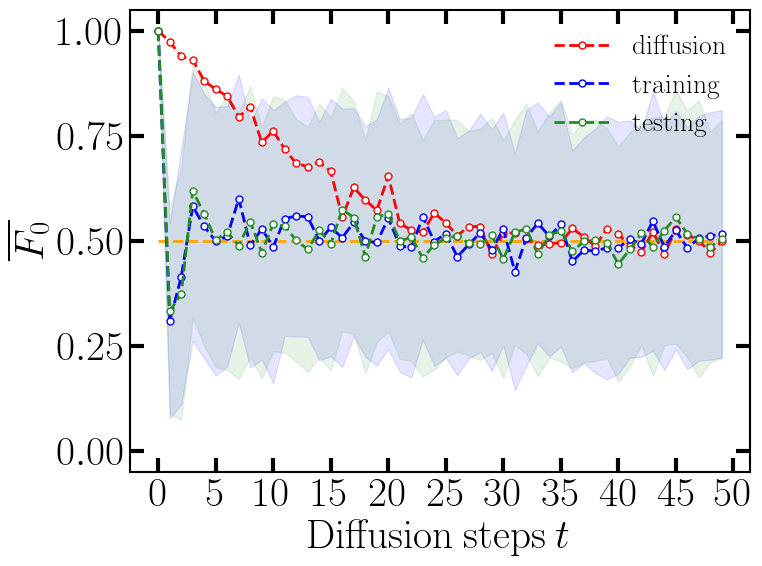

In [65]:
def compute_fidelity(Xout):
    '''
    rewriting the function to give _ALL_ of the fidelty computations before averaging over the batch (for the plot)
    '''
    arr = np.zeros((T,Ndata))
    for i in range(T):
        arr[i] = np.array([np.abs(np.inner(np.conjugate(Xout[0][kk][:]),Xout[i][kk][:]))**2 for kk in range(Ndata)]) 
    return arr
states_train = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]
states_test = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]
states_diff = Xout

F0_train =compute_fidelity(states_train)
F0_test = compute_fidelity(states_test)
F0_diff = compute_fidelity(states_diff)

fig, ax = matplotlib.pyplot.subplots(figsize=(8, 6))

ax.plot(range(T), np.mean(F0_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')
ax.plot(range(T), 0.5*np.ones(T), '--', lw=2, c='orange')

ax.plot(range(T), np.mean(F0_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.fill_between(range(T), np.mean(F0_train, axis=1)-np.std(F0_train, axis=1), 
                    np.mean(F0_train, axis=1)+np.std(F0_train, axis=1), color='b', alpha=0.1)

ax.plot(range(T), np.mean(F0_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm testing$')
ax.fill_between(range(T), np.mean(F0_test, axis=1)-np.std(F0_test, axis=1), 
                    np.mean(F0_test, axis=1)+np.std(F0_test, axis=1), color='forestgreen', alpha=0.1)

ax.legend(fontsize=20, framealpha=0)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(0, T+1, 5))
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\overline{F_0}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
matplotlib.pyplot.rcParams.update({'font.size': 22})
matplotlib.pyplot.rc('font', family='serif')
matplotlib.pyplot.savefig('fidelity151001.pdf', bbox_inches='tight')
matplotlib.pyplot.show()
matplotlib.pyplot.close()

### Visulize the performance in MMD distance

In [70]:
# calculate MMD
X = torch.from_numpy(states_diff)
X_train = torch.from_numpy(states_train)
X_test = torch.from_numpy(states_test)
X0 = torch.from_numpy(circleYGen(100))

mmds = np.zeros((3, T))
for t in range(T):
    idx = np.random.choice(X.shape[1], size=100, replace=False)
    mmds[0, t] = naturalDistance(X0, X[t])
    mmds[1, t] = naturalDistance(X0, X_train[t])
    mmds[2, t] = naturalDistance(X0, X_test[t])


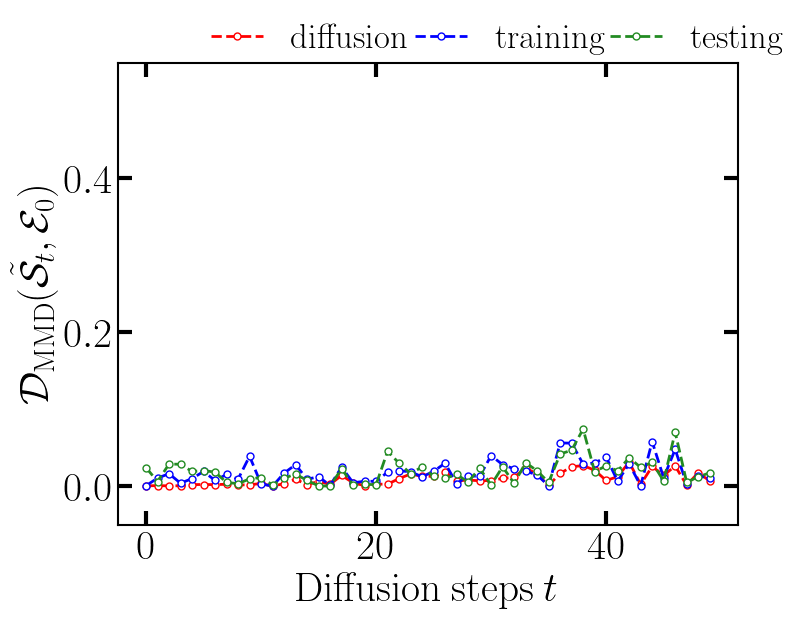

In [71]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mmds[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(mmds[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(mmds[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')

ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.set_ylim(-0.05, 0.55)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

plt.savefig('Circle_MMD.pdf', bbox_inches='tight')
plt.show()
plt.close()

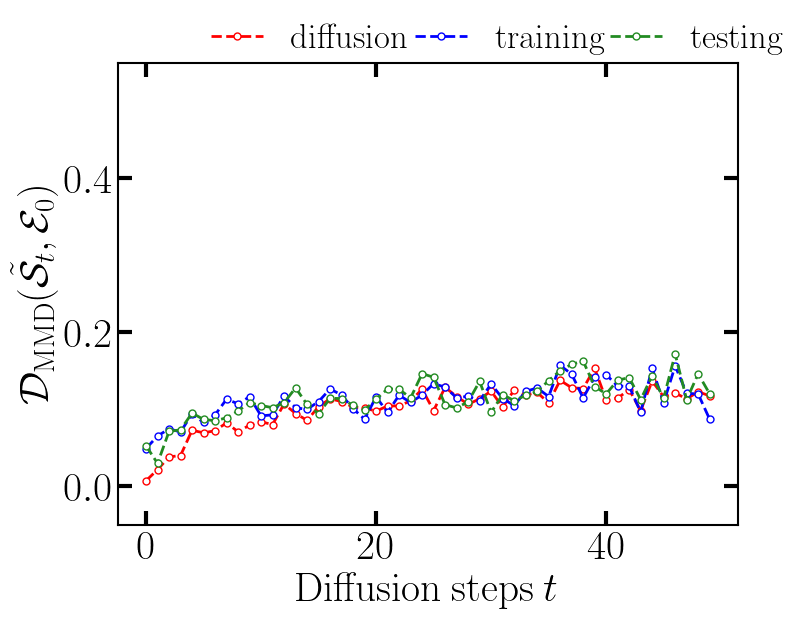

In [72]:
wd = np.zeros((3, T))
for t in range(T):
    idx = np.random.choice(X.shape[1], size=100, replace=False)
    wd[0, t] = WassDistance(X0, X[t])
    wd[1, t] = WassDistance(X0, X_train[t])
    wd[2, t] = WassDistance(X0, X_test[t])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(wd[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(wd[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(wd[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')

ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.set_ylim(-0.05, 0.55)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

plt.savefig('Circle_WD.pdf', bbox_inches='tight')
plt.show()
plt.close()

### Plot the training history

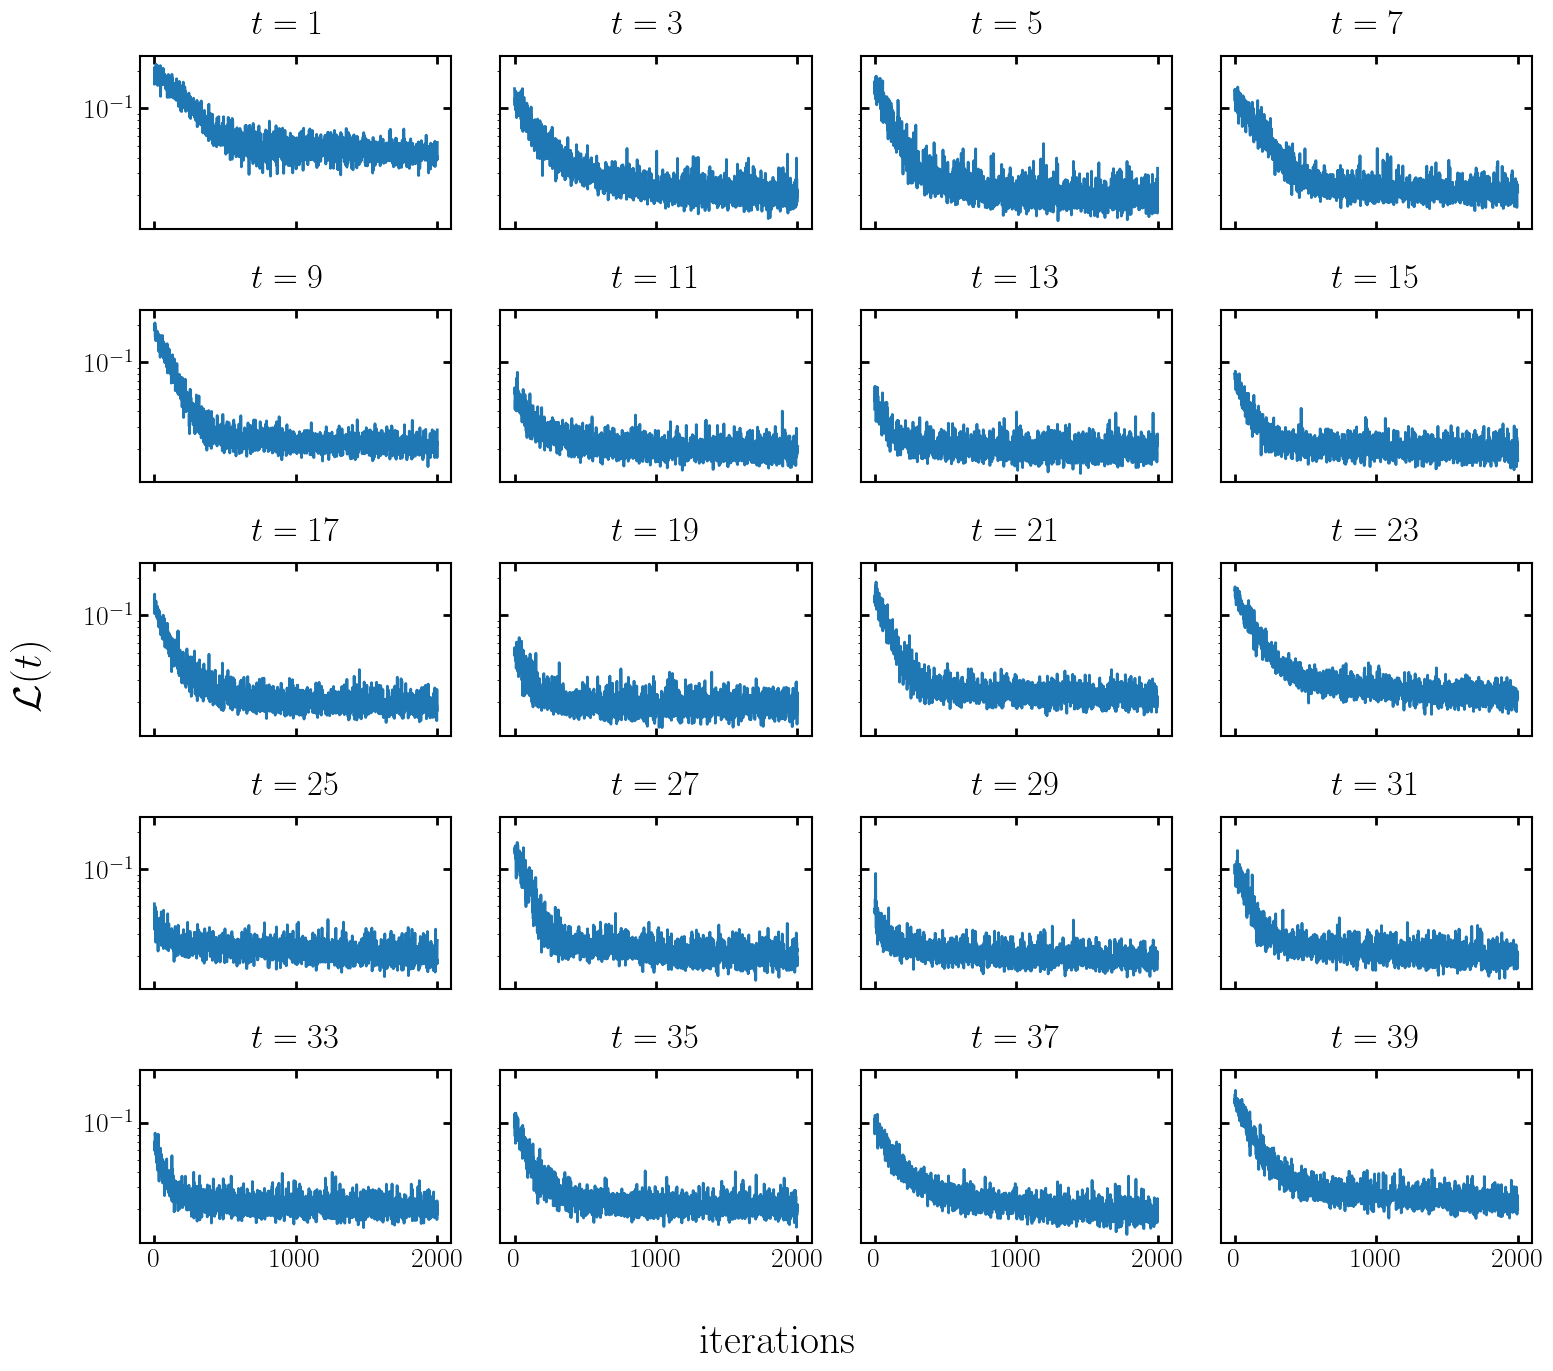

In [73]:
fig, axs = matplotlib.pyplot.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(loss_tot[2*i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=680, y=0.4, s=r'$t=%d$'%(2*i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.savefig('l_iter151001.pdf', bbox_inches='tight')
matplotlib.pyplot.show()

matplotlib.pyplot.close()

# Visualize the diffusion, training, and testing processes on the bloch sphere

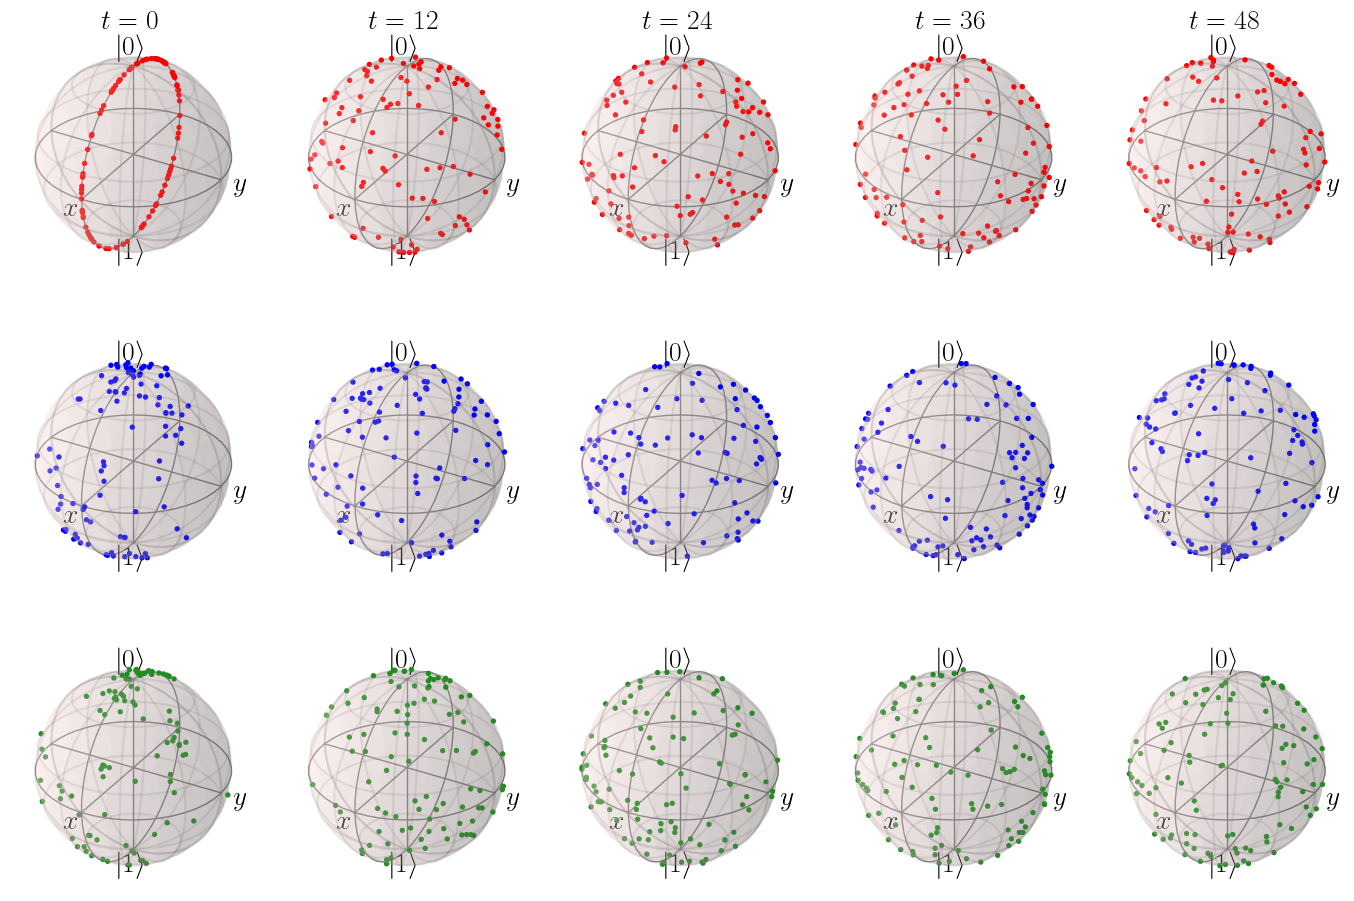

In [75]:
indices = np.random.choice(Ndata, Ndata, replace=False)
states_train = (model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]).detach().numpy()
states_test = (model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]).detach().numpy()
states_diff = Xout

fig, axs = plt.subplots(3,5, figsize=(14,10), subplot_kw={'projection': '3d'})
cc = 0
for i in range(0, T+1, 12):
    xs0, ys0, zs0 = bloch_xyz(states_diff[i])
    xs1, ys1, zs1 = bloch_xyz(states_train[i])
    xs2, ys2, zs2 = bloch_xyz(states_test[i])
    b0 = Bloch(fig=fig, axes=axs[0,cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['r']*Ndata
    b0.point_style = 'm'
    b0.point_size = 8*np.ones(Ndata)
    b0.render()
    b1 = Bloch(fig=fig, axes=axs[1,cc])
    b1.clear()
    b1.add_points([xs1, ys1, zs1])
    b1.point_color = ['b']*Ndata
    b1.point_style = 'm'
    b1.point_size = 8*np.ones(Ndata)
    b1.render()
    b2 = Bloch(fig=fig, axes=axs[2,cc])
    b2.clear()
    b2.add_points([xs2, ys2, zs2])
    b2.point_color = ['forestgreen']*Ndata
    b2.point_style = 'm'
    b2.point_size = 8*np.ones(Ndata)
    b2.render()
    axs[0,cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1
plt.tight_layout()
plt.savefig('Circle_finalBloch1.pdf', bbox_inches='tight')